# Salifort Motors - Workforce Retention Analysis

Salifort Motors' HR department aims to enhance employee satisfaction. The data has been collected but guidance is needed on how to use it effectively. We want to extract insights from the data and provide evidence-based recommendations to the department. Their key concern is understanding what factors might cause an employee to leave the company. The goal of this project is to analyze the HR data and build a predictive model that determines whether an employee will leave the company. By identifying those at risk of leaving, the company can better address retention, which can save the time and cost of recruitment and training.

In [193]:
import warnings
warnings.filterwarnings('ignore')

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

In [195]:
# reading the data
df0 = pd.read_csv("salifort_motors_dataset.csv")
df0 = df0.rename(columns={"Work_accident": "work_accident",
                          "average_montly_hours": "average_monthly_hours",
                          "time_spend_company": "tenure",
                          "Department": "department"})
df0.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

### Initial Data Exploration

In [196]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [197]:
df0.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_monthly_hours        tenure  work_accident          left  \
count           14999.000000  14999.000000   14999.000000  14999.000000   
mean              201.050337      3.498233       0.144610      0.238083   
std                49.943099      1.460136       0.351719      0.425924   
min                96.000000      2.000000       0.000000      0.000000   
25%               156.000000      3.000000       0.000000      0.000000   
50%               200.000000      3.000000       0.000000      0.000000   
75%               245.000000      4.000000       0.000000      0.000000   
max               310.000000     10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [198]:
# checking basic characteristics of the dataset
print("Number of samples:", df0.shape[0])
print("Number of features:", df0.shape[1])
print("Number of missing values:", df0.isna().sum().sum())
print("Number of duplicates:", df0.duplicated().sum())

Number of samples: 14999
Number of features: 10
Number of missing values: 0
Number of duplicates: 3008


In [199]:
# dropping duplicates
df1 = df0.drop_duplicates(keep="first")
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

The dataset comprises 14,999 entries and 10 variables. It has no missing values but contains 3,008 duplicated rows (about 20%). Given the variables are continuous and varied, it seems unlikely that these duplicated entries are legitimate, so it is reasonable to drop them.

### Exploratory Data Analysis

In [285]:
def create_boxplot(title, x_label, y_label, **kwargs):
    """
    This function creates a boxplot.
    """
    plt.figure(figsize=(6,6))
    sns.boxplot(**kwargs)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=20)
    plt.show()


def create_histogram(title, x_label, y_label, xticks_rot=0, fig_size=(6,6), **kwargs):
    """
    This function creates a histogram.
    """
    plt.figure(figsize=fig_size)
    sns.histplot(zorder=3, **kwargs)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(rotation=xticks_rot, fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=20)
    plt.grid(zorder=0)
    plt.show()


def create_scatterplot(title, x_label, y_label, vert_line=166.67, **kwargs):
    """
    This function creates a scatterplot (with an additional vertical line).
    """
    plt.figure(figsize=(16, 9))
    sns.scatterplot(zorder=3, **kwargs)
    plt.axvline(x=vert_line, color="#ff6361", ls="--", zorder=5)
    handles = [ plt.Line2D([], [], linestyle="", marker="o", color="b", label="stayed"),
                plt.Line2D([], [], linestyle="", marker="o", color="orange", label="left"),
                plt.Line2D([], [], linestyle="--", color="#ff6361", label="166.67 hrs./mo.") ]
    plt.legend(handles=handles)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=20)
    plt.grid(zorder=0)
    plt.show()


def create_barplot(title, x_label, y_label, flip_y_axis=False, xticks_rot=0, **kwargs):
    """
    This function creates a barplot.
    """
    plt.figure(figsize=(16, 9))
    sns.barplot(zorder=3, **kwargs)
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.xticks(rotation=xticks_rot, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(title, fontsize=28)
    plt.grid(zorder=0)
    if flip_y_axis:
        plt.gca().invert_yaxis()
    plt.show()

In [201]:
def find_df_outliers(df, col_name, iqr_coeff=1.5):
    """
    This function identifies the subset of data containing outliers and returns
    the remaining data points.
    """
    # calculating the interquartile range based on the 25th and 75th percentile values
    percentile25 = df[col_name].quantile(0.25)
    percentile75 = df[col_name].quantile(0.75)
    iqr = percentile75 - percentile25

    # calculating the lower and upper limits for non-outlier values
    lower_limit = percentile25 - (iqr_coeff * iqr)
    upper_limit = percentile75 + (iqr_coeff * iqr)
    print("Lower limit:", lower_limit)
    print("Upper limit:", upper_limit)

    # finding outliers
    outliers = df[(df[col_name] < lower_limit) | (df[col_name] > upper_limit)]
    print("Number of outliers in", col_name + ":", len(outliers))

    return df[(df[col_name] >= lower_limit) | (df[col_name] <= upper_limit)]

In [202]:
# getting the number of employees by leave status
print("Number Of Employees By Leave Status")
print(df1["left"].value_counts())
print()

# getting the percentage of employees by leave status
print("Percentage Of Employees By Leave Status")
print(df1["left"].value_counts(normalize=True))
print()

# getting the number of employees with 7 projects by leave status
print("Number Of Employees With 7 Projects By Leave Status")
print(df1[df1["number_project"]==7]["left"].value_counts())
print()

# getting the number of employees who did not receive a promotion in the last 5 years by leave status
print("Number Of Employees Without Recent Promotion By Leave Status")
print(df1[df1["promotion_last_5years"]==0]["left"].value_counts())
print()

# getting the number of employees who received a promotion in the last 5 years by leave status
print("Number Of Employees With Recent Promotion By Leave Status")
print(df1[df1["promotion_last_5years"]==1]["left"].value_counts())

Number Of Employees By Leave Status
left
0    10000
1     1991
Name: count, dtype: int64

Percentage Of Employees By Leave Status
left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

Number Of Employees With 7 Projects By Leave Status
left
1    145
Name: count, dtype: int64

Number Of Employees Without Recent Promotion By Leave Status
left
0    9805
1    1983
Name: count, dtype: int64

Number Of Employees With Recent Promotion By Leave Status
left
0    195
1      8
Name: count, dtype: int64


In [203]:
# getting counts for each department
df1["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

In [204]:
# calculating the mean and median satisfaction scores of employees by leave status
df1.groupby(["left"])["satisfaction_level"].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

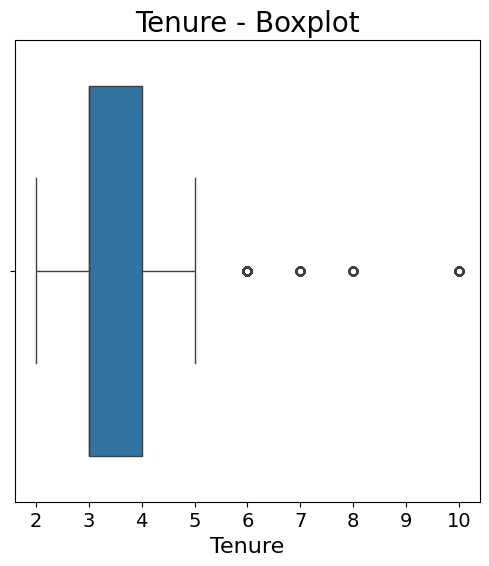

In [205]:
# creating a boxplot for the number of projects by leave status
create_boxplot("Tenure - Boxplot", "Tenure", "", x=df1["tenure"])

In [206]:
# finding outliers for the tenure
_ = find_df_outliers(df1, "tenure")

Lower limit: 1.5
Upper limit: 5.5
Number of outliers in tenure: 824


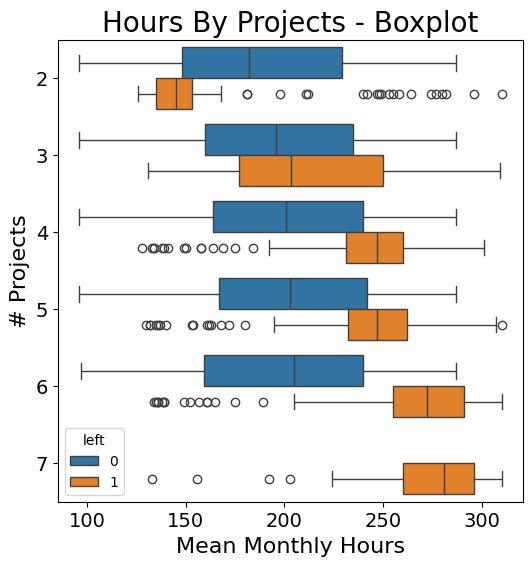

In [207]:
# creating a boxplot for the average monthly hours by number of projects
create_boxplot("Hours By Projects - Boxplot",
               "Mean Monthly Hours",
               "# Projects",
               data=df1,
               x="average_monthly_hours",
               y="number_project",
               hue="left",
               orient="h")

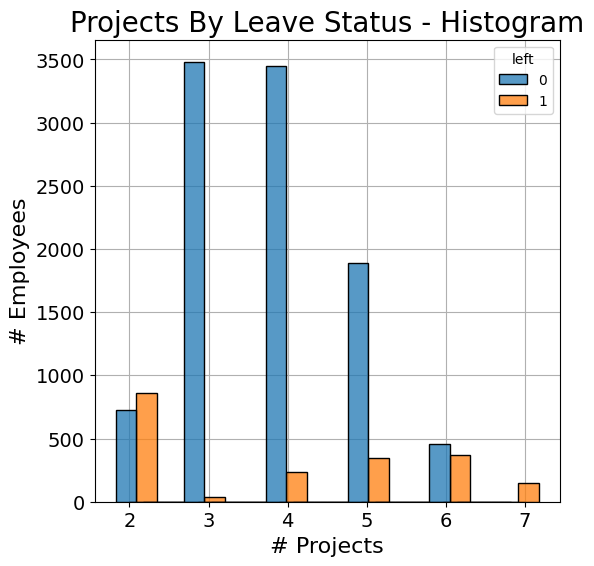

In [208]:
# creating a histogram for the number of projects by leave status
create_histogram("Projects By Leave Status - Histogram",
                 "# Projects",
                 "# Employees",
                 data=df1,
                 x="number_project",
                 hue="left",
                 multiple="dodge",
                 shrink=3)

Certain models are more sensitive to outliers than others, so the choice of model will influence how you handle these outliers. Employees working on more projects tend to log longer hours, but two notable groups emerge among those who left:

* Employees who worked fewer hours compared to their peers
* Employees who put in significantly more hours.

The first group might include employees who were let go or had already given notice, while the second group likely consists of those who resigned due to heavy workloads. Interestingly, all employees involved in seven projects eventually left the company. For employees with six or seven projects, their monthly working hours were considerably higher (around 255 - 295 hours per month). The ideal number of projects appears to be 3 - 4, as employees in these groups showed a low turnover rate.

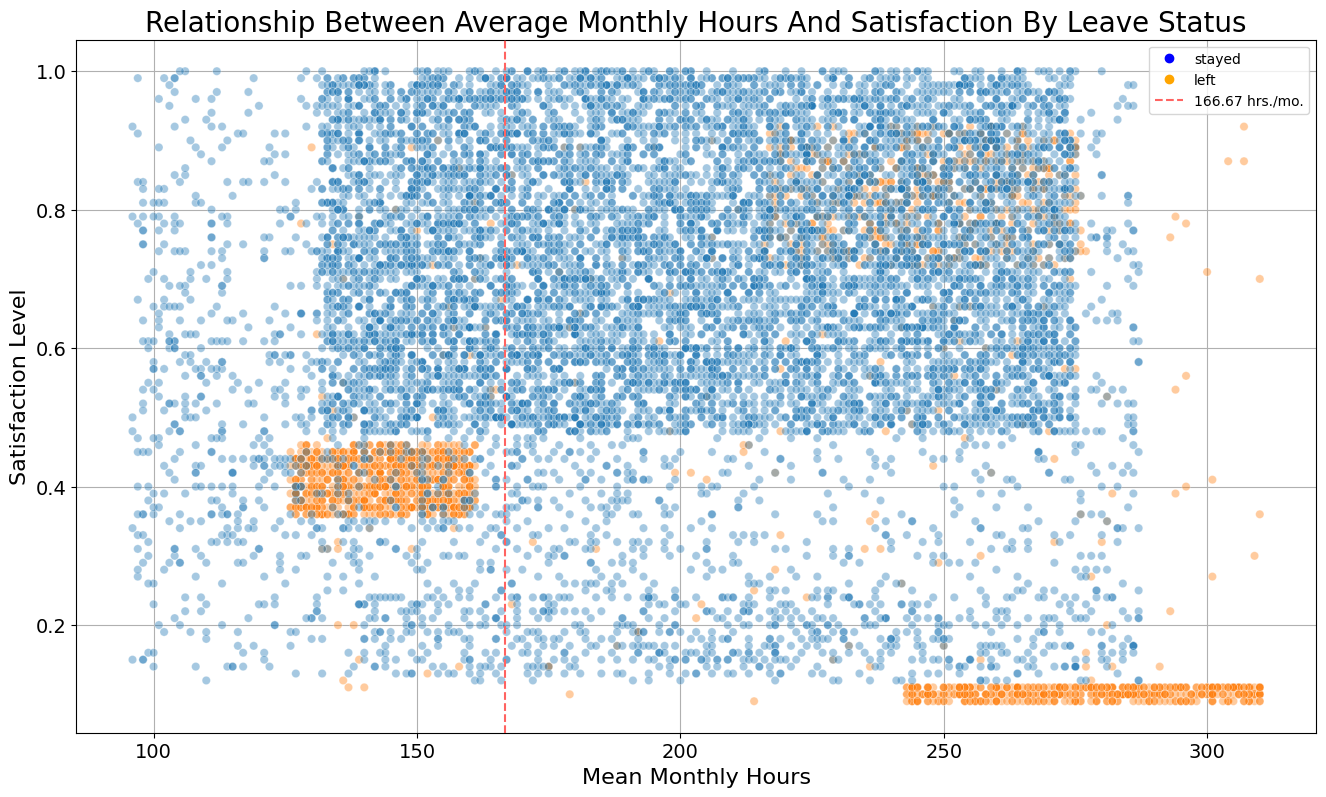

In [209]:
# creating a scatterplot for the relationship between monthly hours and satisfaction by leave status
create_scatterplot("Relationship Between Average Monthly Hours And Satisfaction By Leave Status",
                   "Mean Monthly Hours",
                   "Satisfaction Level",
                   data=df1,
                   x="average_monthly_hours",
                   y="satisfaction_level",
                   hue="left",
                   alpha=0.4)

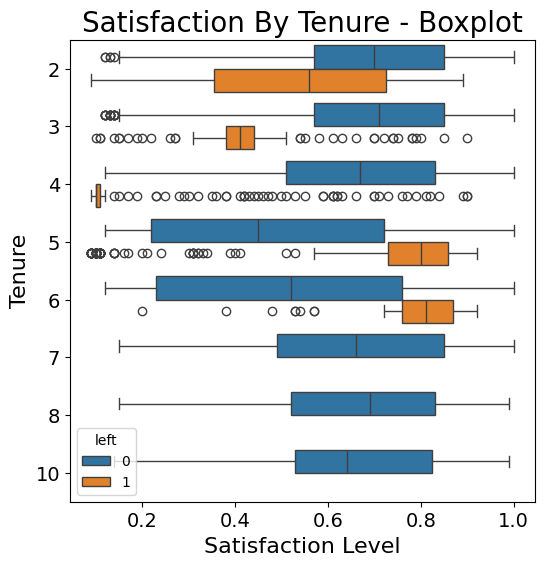

In [210]:
# creating a boxplot for the satisfaction by tenure
create_boxplot("Satisfaction By Tenure - Boxplot",
               "Satisfaction Level",
               "Tenure",
               data=df1,
               x="satisfaction_level",
               y="tenure",
               hue="left",
               orient="h")

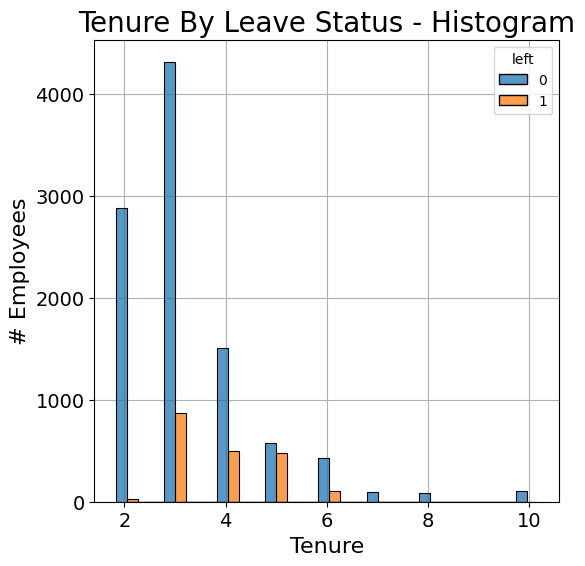

In [211]:
# creating a histogram for the tenure by leave status
create_histogram("Tenure By Leave Status - Histogram",
                 "Tenure",
                 "# Employees",
                 data=df1,
                 x="tenure",
                 hue="left",
                 multiple="dodge",
                 shrink=5)

In [212]:
# isolating short-tenured employees
tenure_short = df1[df1["tenure"] < 7]

# isolating long-tenured employees
tenure_long = df1[df1["tenure"] > 6]

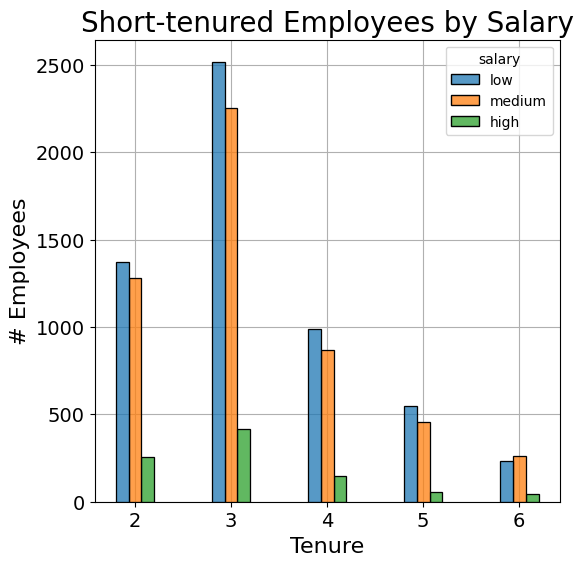

In [213]:
# creating a histogram for the short-tenured employees by salary
create_histogram("Short-tenured Employees by Salary",
                 "Tenure",
                 "# Employees",
                 data=tenure_short,
                 x="tenure",
                 hue="salary",
                 discrete=1,
                 hue_order=["low", "medium", "high"],
                 multiple="dodge",
                 shrink=.4)

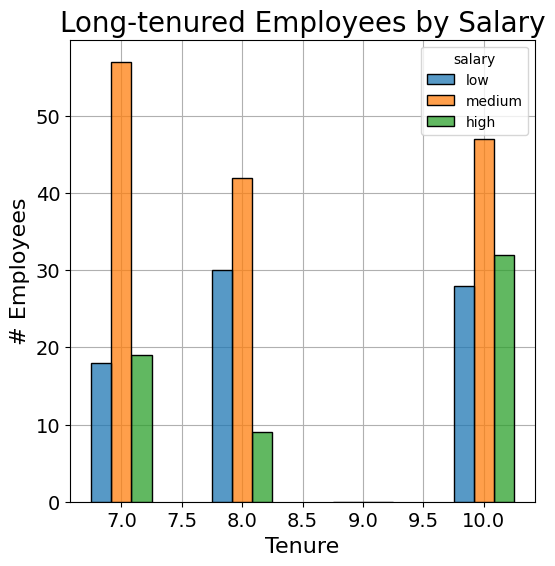

In [214]:
# creating a histogram for the long-tenured employees by salary
create_histogram("Long-tenured Employees by Salary",
                 "Tenure",
                 "# Employees",
                 data=tenure_long,
                 x="tenure",
                 hue="salary",
                 discrete=1,
                 hue_order=["low", "medium", "high"],
                 multiple="dodge",
                 shrink=.5)

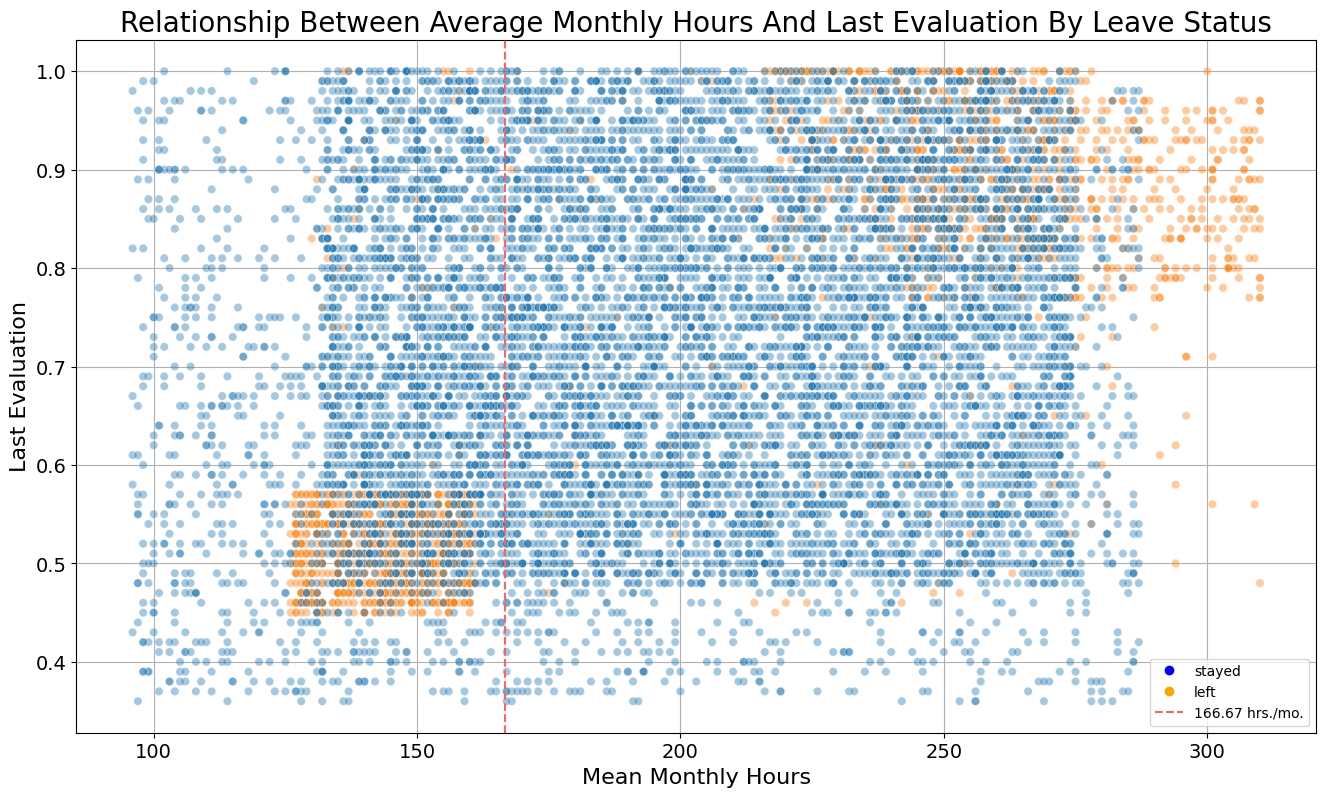

In [215]:
# creating a scatterplot for the relationship between monthly hours and satisfaction by leave status
create_scatterplot("Relationship Between Average Monthly Hours And Last Evaluation By Leave Status",
                   "Mean Monthly Hours",
                   "Last Evaluation",
                   data=df1,
                   x="average_monthly_hours",
                   y="last_evaluation",
                   hue="left",
                   alpha=0.4)

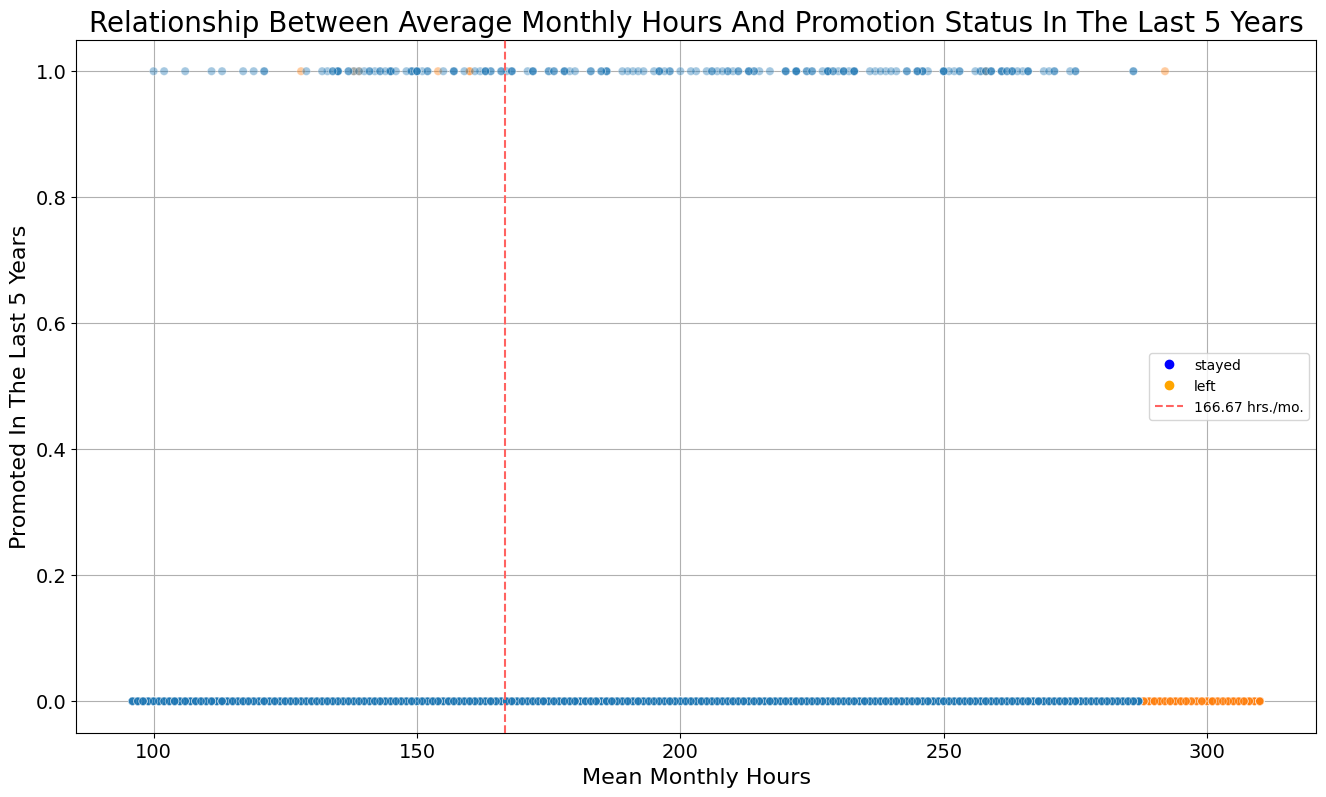

In [216]:
# creating a scatterplot for the relationship between monthly hours and promotion status in 5 years
create_scatterplot("Relationship Between Average Monthly Hours And Promotion Status In The Last 5 Years",
                   "Mean Monthly Hours",
                   "Promoted In The Last 5 Years",
                   data=df1,
                   x="average_monthly_hours",
                   y="promotion_last_5years",
                   hue="left",
                   alpha=0.4)

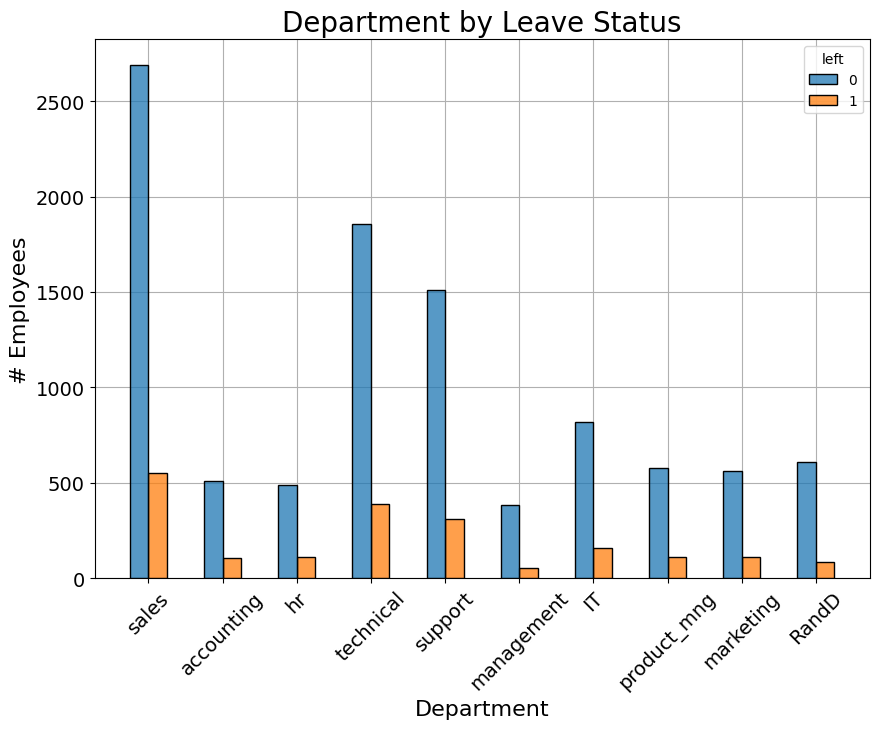

In [217]:
# creating a histogram for the department distribution by leave status
create_histogram("Department by Leave Status",
                 "Department",
                 "# Employees",
                 45,
                 (10,7),
                 data=df1,
                 x="department",
                 hue="left",
                 discrete=1,
                 hue_order=[0,1],
                 multiple="dodge",
                 shrink=.5)

Text(0.5, 1.0, 'Correlation Heatmap')

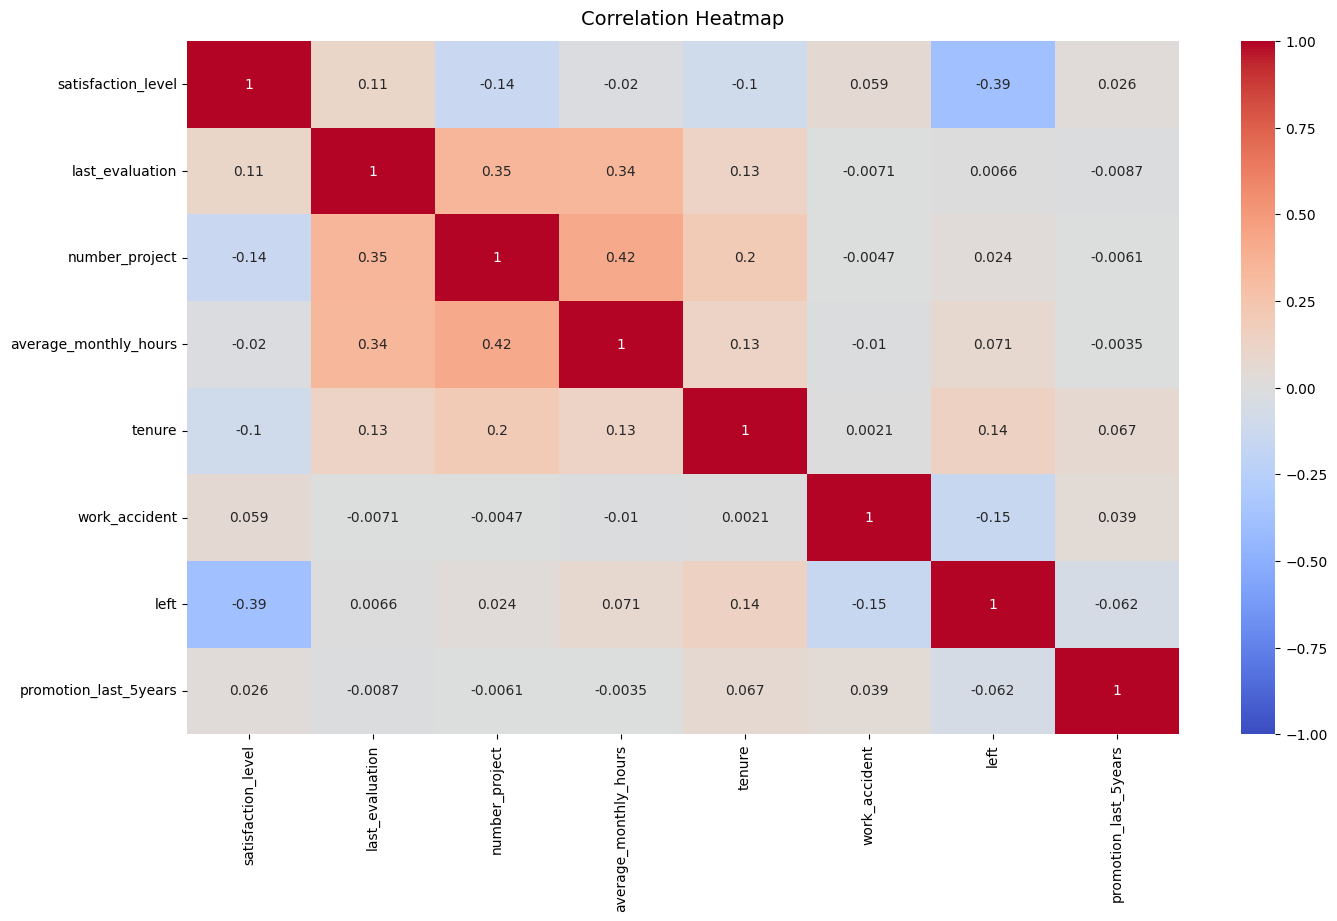

In [218]:
# creating a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(method="pearson", numeric_only=True),
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap=sns.color_palette("coolwarm", as_cmap=True))
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize":14}, pad=12)

A scatterplot indicates a large number of employees worked between 240 - 315 hours monthly, with satisfaction levels close to zero. This is over 75 hours per week, likely contributing to their dissatisfaction. Another group worked more typical hours but had satisfaction levels around 0.4, suggesting they might have felt pressured due to the high workloads of their peers. Employees fall into two main categories based on satisfaction and tenure:

* Dissatisfied short-term employees
* Very satisfied employees with medium tenure.

The longest-serving employees typically stayed and their satisfaction levels were similar to new hires who also remained. Long-tenured employees made up a small percentage of the workforce and might be more senior or higher-paid.

### Model Building

Since the goal is to predict employee turnover (a binary outcome), logistic regression or tree-based models are suitable choices.

In [219]:
def get_best_cv_results(model_name:str, model_object, metric:str):
    """
    This function returns a dataframe with the performance scores for the model
    with the best mean of a given metric across all validation folds.
    """
    # creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {"auc": "mean_test_roc_auc",
                   "precision": "mean_test_precision",
                   "recall": "mean_test_recall",
                   "f1": "mean_test_f1",
                   "accuracy": "mean_test_accuracy"
                  }

    # getting all the results from the CV
    cv_results = pd.DataFrame(model_object.cv_results_)

    # isolating the row of the dataframe with the max score of the given metric
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # extracting performance scores
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # creating table of results
    table = pd.DataFrame({"Model": [model_name],
                          "Precision": [precision],
                          "Recall": [recall],
                          "F1": [f1],
                          "Accuracy": [accuracy],
                          "AUC": [auc]
                        })

    return table


def get_test_results(model_name:str, model, X_test_data, y_test_data):
    """
    This function generates a table of test scores (precision, recall, f1, accuracy, AUC).
    """
    # getting predictions on testing data
    preds = model.best_estimator_.predict(X_test_data)

    # calculating performance scores
    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    # creating table of results
    table = pd.DataFrame({"Model": [model_name],
                          "Precision": [precision],
                          "Recall": [recall],
                          "F1": [f1],
                          "Accuracy": [accuracy],
                          "AUC": [auc]
                        })

    return table


def create_confusion_matrix(y_target, y_pred, model_classes, target_classes):
    """
    This function displays a confusion matrix.
    """
    # computing the values of the confusion matrix and diplaying it
    cm = confusion_matrix(y_target, y_pred, labels=model_classes)
    log_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    log_disp.plot(values_format="")
    plt.show()

In [220]:
target_classes = ["Stayed", "Left"]

In [221]:
# encoding the data
encoded_features = df1.copy()
encoded_features["salary"] = (encoded_features["salary"].astype("category")
                              .cat.set_categories(["low", "medium", "high"])
                              .cat.codes)
encoded_features = pd.get_dummies(encoded_features, drop_first=False)
encoded_features.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

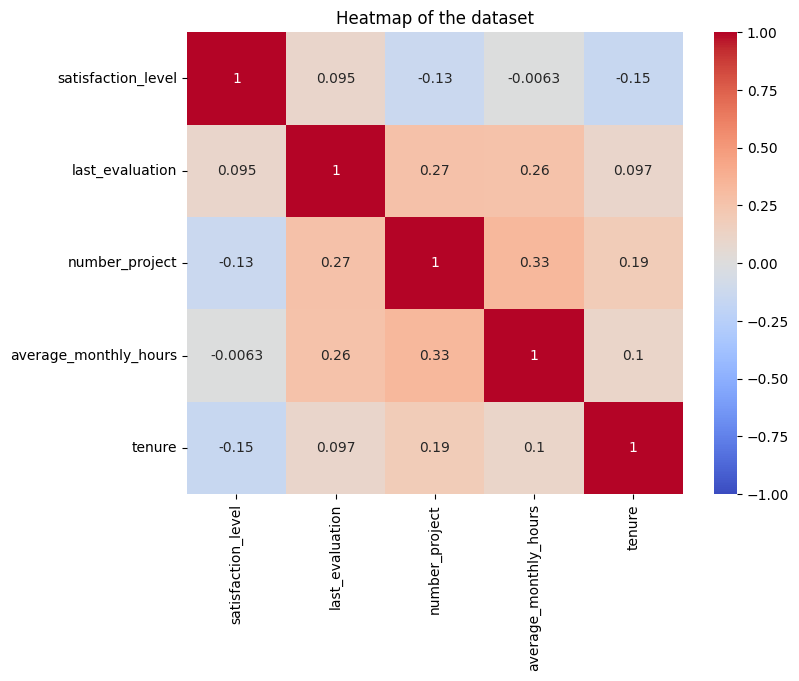

In [222]:
# creating a correlation heatmap only with potential key features
plt.figure(figsize=(8, 6))
sns.heatmap(encoded_features[["satisfaction_level",
                              "last_evaluation",
                              "number_project",
                              "average_monthly_hours",
                              "tenure"]].corr(),
             vmin=-1,
             vmax=1,
             annot=True,
             cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title("Heatmap of the dataset")
plt.show()

#### Logistic Regression Model

Key assumptions of logistic regression include:

* The outcome variable is categorical.
* Observations are independent.
* There is no severe multicollinearity among the predictors.
* There are no extreme outliers.
* The relationship between each predictor and the logit of the outcome is linear.
* The sample size is large enough for reliable results.

Since the goal is to predict employee turnover (a binary outcome), logistic regression is a suitable choice. This section covers the implementation of Logistic Regression.

In [223]:
# removing outliers for the tenure
df_logreg = find_df_outliers(encoded_features, "tenure")
df_logreg.head()

Lower limit: 1.5
Upper limit: 5.5
Number of outliers in tenure: 824


satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [224]:
# checking class balance
df_logreg["left"].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [225]:
# isolating the predictors (X) and the target variable (Y)
y = df_logreg["left"]
X = df_logreg.drop("left", axis=1)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [226]:
# fitting the logistic regression model to the training data
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [227]:
# getting predictions on the testing data for the logistic regression model
y_pred = log_clf.predict(X_test)

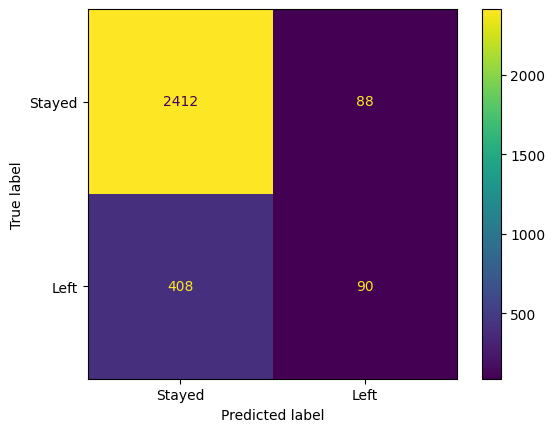

In [228]:
# creating confusion matrix for the logistic regression model
create_confusion_matrix(y_test, y_pred, log_clf.classes_, target_classes)

In [229]:
# creating a classification report for the logistic regression model
print(classification_report(y_test, y_pred, target_names=target_classes))

              precision    recall  f1-score   support

      Stayed       0.86      0.96      0.91      2500
        Left       0.51      0.18      0.27       498

    accuracy                           0.83      2998
   macro avg       0.68      0.57      0.59      2998
weighted avg       0.80      0.83      0.80      2998



#### Tree-based Models Without Feature Engineering

Since the goal is to predict employee turnover (a binary outcome), tree-based models are suitable choices. This section covers the implementation of Decision Tree and Random Forest.

In [230]:
# isolating the predictors (X) and the target variable (Y)
y = encoded_features["left"]
X = encoded_features.drop("left", axis=1)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [231]:
# decision tree model for classification
decision_tree_clf1 = DecisionTreeClassifier(random_state=0)

# hyperparameters for tuning
cv_params = { "max_depth":[4, 6, 8, None],
              "min_samples_leaf": [2, 5, 1],
              "min_samples_split": [2, 4, 6] }

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# GridSearchCV object
decision_tree_cv1 = GridSearchCV(decision_tree_clf1,
                                 cv_params,
                                 scoring=scoring_criteria,
                                 cv=4,
                                 refit="roc_auc")

In [ ]:
# fitting the decision tree model to the training data
decision_tree_cv1.fit(X_train, y_train)

In [233]:
# examining best score
decision_tree_cv1.best_score_

0.969819392792457

In [234]:
# examining best architecture
decision_tree_cv1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [235]:
# getting best results of GridSearch based on a specific metric
decision_tree_cv1_results = get_best_cv_results("Decision Tree 1 CV", decision_tree_cv1, "auc")
decision_tree_cv1_results

Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 1 CV   0.914552  0.916949  0.915707  0.971978  0.969819

In [236]:
# random forest model for classification
random_forest_clf1 = RandomForestClassifier(random_state=0)

# hyperparameters for tuning
cv_params = { "max_depth": [3, 5, None],
              "max_features": [1.0],
              "max_samples": [0.7, 1.0],
              "min_samples_leaf": [1, 2 ,3],
              "min_samples_split": [2, 3, 4],
              "n_estimators": [300, 500] }

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# GridSearchCV object
random_forest_cv1 = GridSearchCV(random_forest_clf1,
                                 cv_params,
                                 scoring=scoring_criteria,
                                 cv=4,
                                 refit="roc_auc")

In [ ]:
# fitting the random forest model to the training data
random_forest_cv1.fit(X_train, y_train)

In [238]:
# examining best score
random_forest_cv1.best_score_

0.9804250949807172

In [239]:
# examining best architecture
random_forest_cv1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [240]:
# getting best results of GridSearch based on a specific metric
random_forest_cv1_results = get_best_cv_results("Random Forest 1 CV", random_forest_cv1, "auc")
print(decision_tree_cv1_results)
print(random_forest_cv1_results)

                Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 1 CV   0.914552  0.916949  0.915707  0.971978  0.969819
                Model  Precision    Recall        F1  Accuracy       AUC
0  Random Forest 1 CV   0.950023  0.915614  0.932467  0.977983  0.980425


In [241]:
# getting results on testing data for the random forest model
random_forest_test_scores1 = get_test_results("Random Forest 1 Test", random_forest_cv1, X_test, y_test)
random_forest_test_scores1

Model  Precision    Recall        F1  Accuracy       AUC
0  Random Forest 1 Test   0.964211  0.919679  0.941418  0.980987  0.956439

#### Tree-based Models With Feature Engineering

To improve model performance and prevent data leakage, it is important to consider which features to include. For instance, the variable `satisfaction_level` for the satisfaction score might not be available for all employees, so using it could introduce bias. A new binary feature called overworked could help capture whether an employee works more than 175 hours per month (above the average of 166.67 hours for a standard 40-hour workweek).

In [242]:
# checking the mean, the median, the minimum and the maximum average monthly hours
print("----- Average Monthly Hours -----")
print("Mean:", encoded_features["average_monthly_hours"].mean())
print("Median:", encoded_features["average_monthly_hours"].median())
print("Min:", encoded_features["average_monthly_hours"].min())
print("Max:", encoded_features["average_monthly_hours"].max())

----- Average Monthly Hours -----
Mean: 200.4735218080227
Median: 200.0
Min: 96
Max: 310


In [243]:
# dropping the column for the satisfaction level
df2 = encoded_features.drop("satisfaction_level", axis=1)

# creating a new column for the overworking status
df2["overworked"] = df2["average_monthly_hours"]
df2["overworked"] = (df2["overworked"] > 175).astype(int)

# dropping the column for the average monthly hours
df2 = df2.drop("average_monthly_hours", axis=1)

In [244]:
# isolating the predictors (X) and the target variable (Y)
y = df2["left"]
X = df2.drop("left", axis=1)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [245]:
# decision tree model for classification
decision_tree_clf2 = DecisionTreeClassifier(random_state=0)

# hyperparameters for tuning
cv_params = { "max_depth":[4, 6, 8, None],
              "min_samples_leaf": [2, 5, 1],
              "min_samples_split": [2, 4, 6] }

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# GridSearchCV object
decision_tree_cv2 = GridSearchCV(decision_tree_clf2,
                                 cv_params,
                                 scoring=scoring_criteria,
                                 cv=4,
                                 refit="roc_auc")

In [ ]:
# fitting the decision tree model to the training data
decision_tree_cv2.fit(X_train, y_train)

In [247]:
# examining best score
decision_tree_cv2.best_score_

0.9586752505340426

In [248]:
# examining best architecture
decision_tree_cv2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [249]:
# getting best results of GridSearch based on a specific metric
decision_tree_cv2_results = get_best_cv_results("Decision Tree 2 CV", decision_tree_cv2, "auc")
print(decision_tree_cv1_results)
print(decision_tree_cv2_results)

                Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 1 CV   0.914552  0.916949  0.915707  0.971978  0.969819
                Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 2 CV   0.856693  0.903553  0.878882  0.958523  0.958675


In [250]:
# random forest model for classification
random_forest_clf2 = RandomForestClassifier(random_state=0)

# hyperparameters for tuning
cv_params = { "max_depth": [3, 5, None],
              "max_features": [1.0],
              "max_samples": [0.7, 1.0],
              "min_samples_leaf": [1, 2, 3],
              "min_samples_split": [2, 3, 4],
              "n_estimators": [300, 500] }

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# GridSearchCV object
random_forest_cv2 = GridSearchCV(random_forest_clf2,
                                 cv_params,
                                 scoring=scoring_criteria,
                                 cv=4,
                                 refit="roc_auc")

In [ ]:
# fitting the decision tree model to the training data
random_forest_cv2.fit(X_train, y_train)

In [252]:
# examining best score
random_forest_cv2.best_score_

0.9648100662833985

In [253]:
# examining best architecture
random_forest_cv2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [254]:
# getting best results of GridSearch based on a specific metric
random_forest_cv2_results = get_best_cv_results("Random Forest 2 CV", random_forest_cv2, "auc")
print(decision_tree_cv2_results)
print(random_forest_cv2_results)

                Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 2 CV   0.856693  0.903553  0.878882  0.958523  0.958675
                Model  Precision    Recall        F1  Accuracy      AUC
0  Random Forest 2 CV   0.866758  0.878754  0.872407  0.957411  0.96481


In [255]:
# getting results on testing data for the random forest model
random_forest_test_scores2 = get_test_results("Random Forest 2 Test", random_forest_cv2, X_test, y_test)
random_forest_test_scores2

Model  Precision    Recall      F1  Accuracy       AUC
0  Random Forest 2 Test   0.870406  0.903614  0.8867  0.961641  0.938407

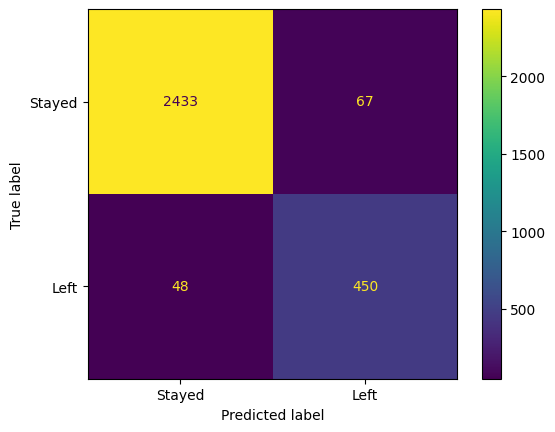

In [256]:
# creating confusion matrix for the random forest model
create_confusion_matrix(y_test,
                        random_forest_cv2.best_estimator_.predict(X_test),
                        random_forest_cv2.classes_,
                        target_classes)

After removing outliers, features are refined to reduce data leakage and improve model robustness. For the logistic regression model we have the following weighted average scores:

* Precision: 80%
* Recall: 83%
* F1-score: 80%
* Accuracy: 83%

However, if the focus is on predicting employees who leave, then the scores are significantly lower for the logistic regression. For tree-based models, the random forest slightly outperformed the decision tree, yielding the following testing scores:

* Precision: 87%
* Recall: 90%
* F1-score: 88%
* Accuracy: 96%
* AUC: 93%

Random forest models are effective at avoiding overfitting and the test results suggest good generalization to unseen data.

### Feature Significance

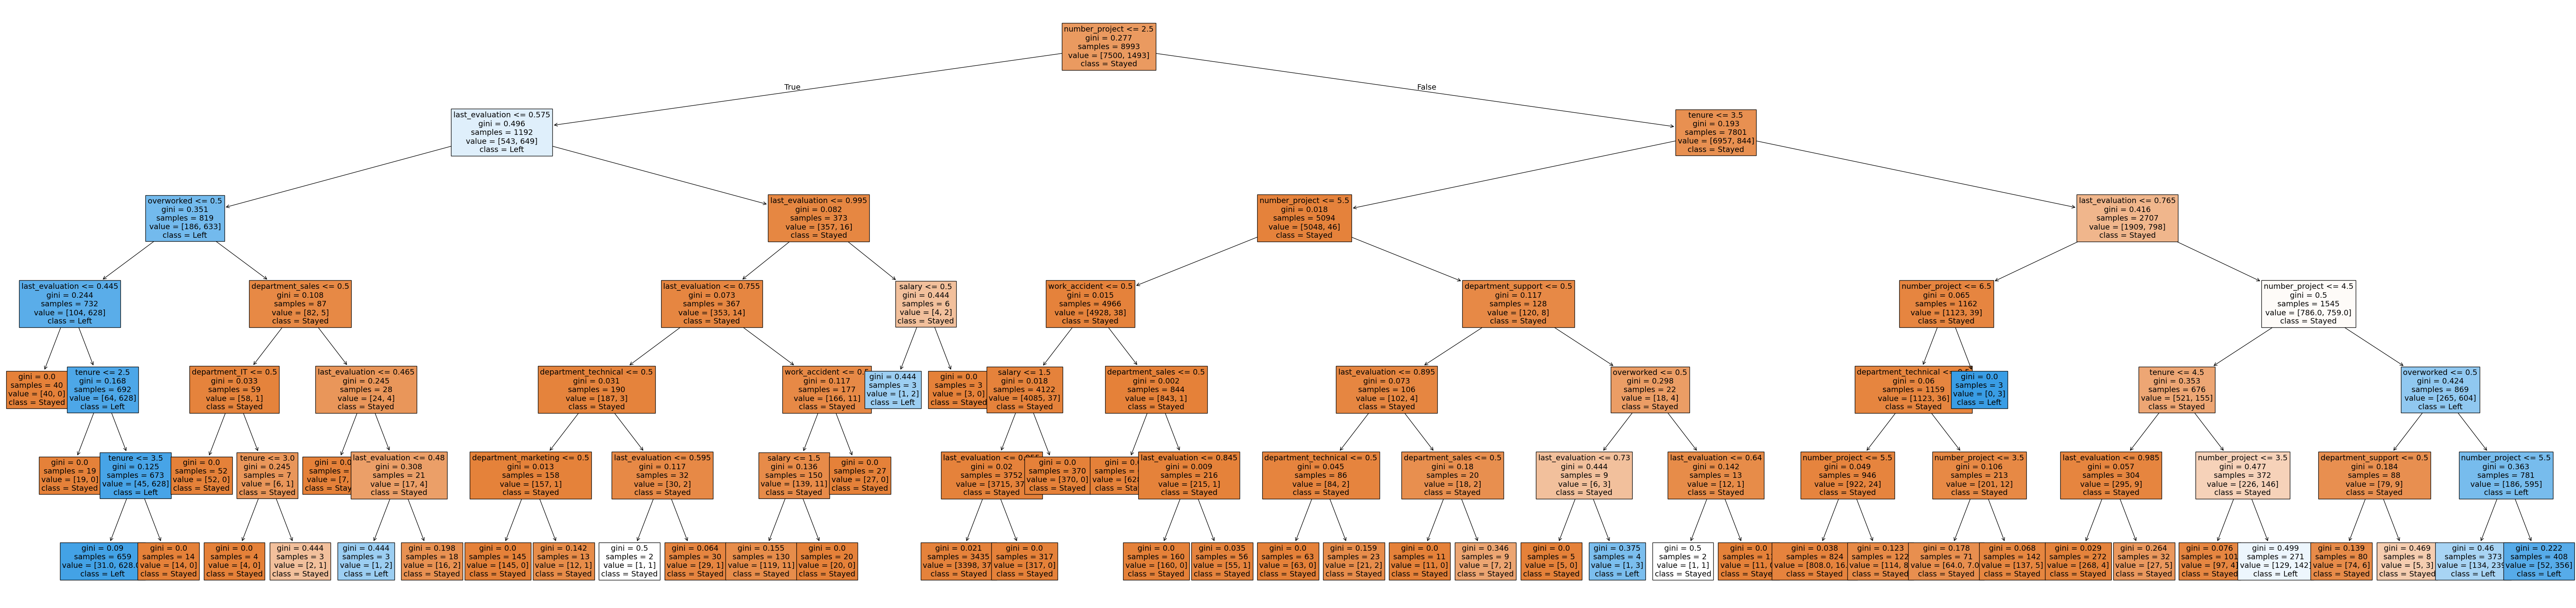

In [257]:
# plotting the decision tree to inspect the splits
plt.figure(figsize=(85,20))
plot_tree(decision_tree_cv2.best_estimator_,
          max_depth=6,
          fontsize=14,
          feature_names=X.columns,
          class_names={0:"Stayed", 1:"Left"},
          filled=True);
plt.show()

In [258]:
# getting the importance of the non-negligible features for the decision tree
decision_tree_significance = pd.DataFrame(decision_tree_cv2.best_estimator_.feature_importances_,
                                              columns=["gini_importance"],
                                              index=X.columns)
decision_tree_significance = decision_tree_significance.sort_values(by="gini_importance",
                                                                        ascending=False)
decision_tree_significance = decision_tree_significance[decision_tree_significance["gini_importance"] != 0]
decision_tree_significance

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

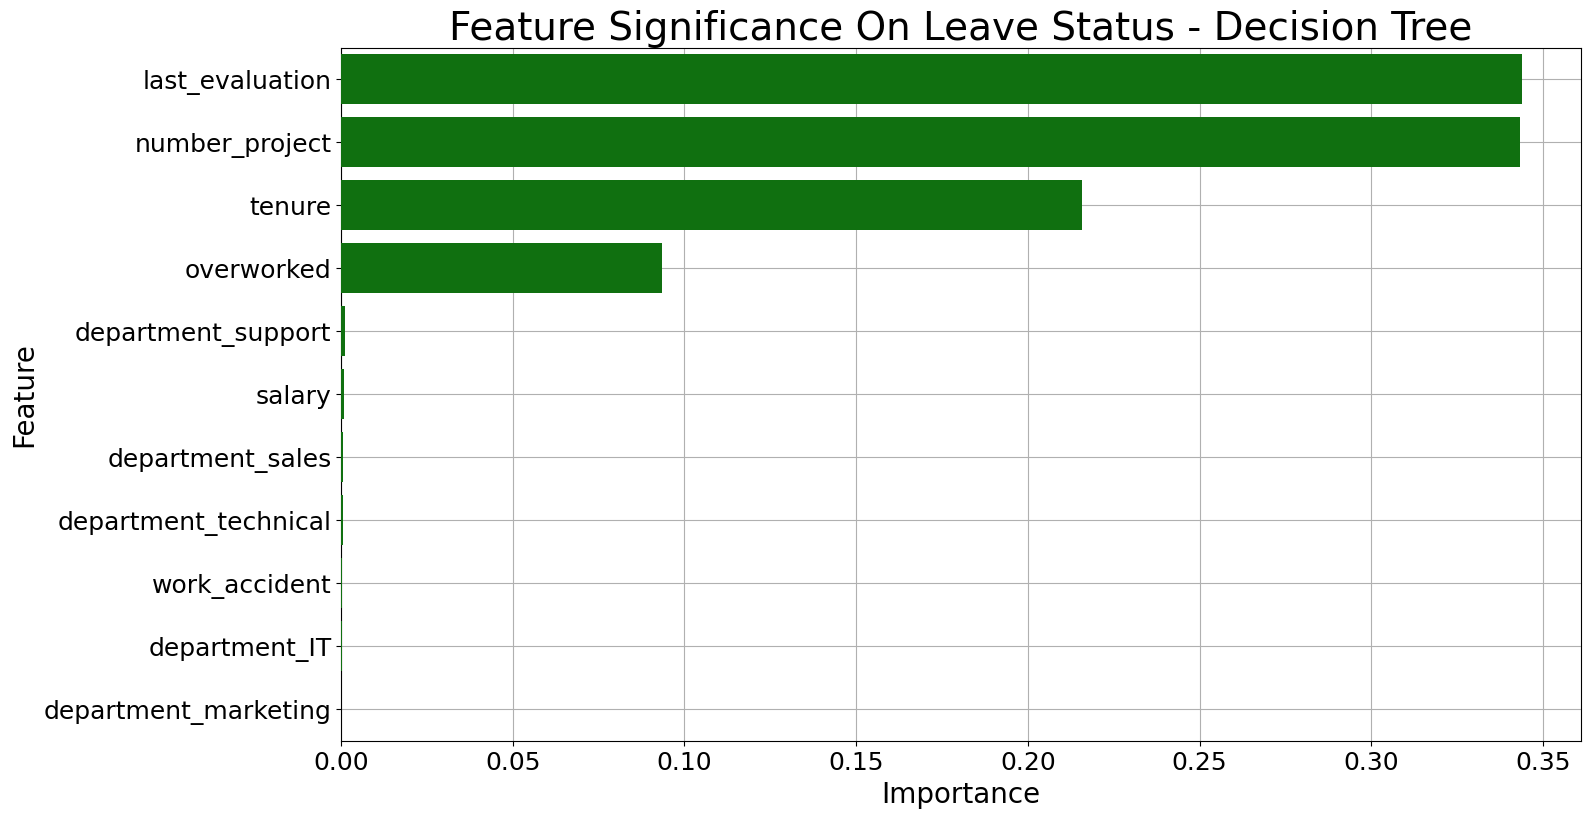

In [297]:
# creating a barplot for the feature significance of the final decision tree model
create_barplot("Feature Significance On Leave Status - Decision Tree",
               "Importance",
               "Feature",
               data=decision_tree_significance,
               x="gini_importance",
               y=decision_tree_significance.index,
               color="green",
               orient="h")

In [283]:
# getting the importance of the top 10 features for the final random forest model
random_forest_significance = random_forest_cv2.best_estimator_.feature_importances_
indices = np.argpartition(random_forest_cv2.best_estimator_.feature_importances_, -10)[-10:]
random_forest_significance = random_forest_significance[indices]
random_forest_significance = pd.DataFrame({"Feature": X.columns[indices],
                                           "Importance": random_forest_significance})
random_forest_significance = random_forest_significance.sort_values("Importance")

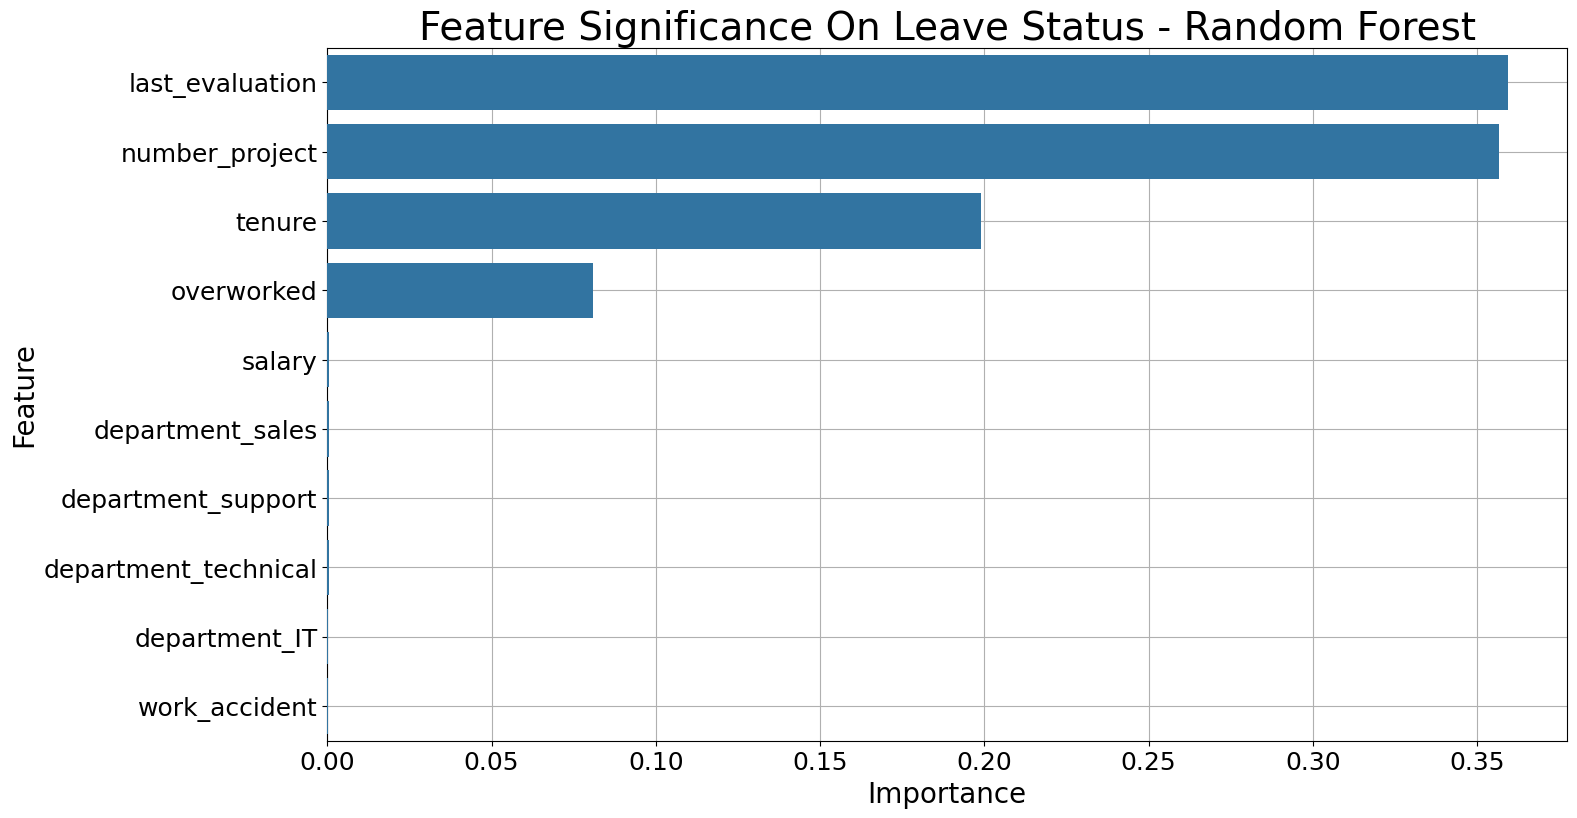

In [296]:
# creating a barplot for the feature significance of the random forest
create_barplot("Feature Significance On Leave Status - Random Forest",
               "Importance",
               "Feature",
               True,
               data=random_forest_significance,
               x="Importance",
               y="Feature",
               orient="h")

The most influential factors identified by both tree-based models include `last_evaluation`, `number_project`, `tenure` and `overworked`, which are crucial in predicting whether an employee will leave.

### Final Thoughts

The analysis suggests that overwork and lack of recognition are driving turnover at the company. Recommendations include:

* Limiting the number of projects assigned to employees.
* Offering promotions or further investigating dissatisfaction among those with four years of tenure.
* Rewarding employees who work longer hours or reducing the need for such hours.
* Clarifying company policies around overtime pay and workload expectations.
* Holding discussions on work culture and expectations at the company.

For future analysis, it might be valuable to explore models without certain features like `last_evaluation` or `satisfaction_level`, which could be less reliable in a real-world deployment. Additionally, clustering analysis using K-means could reveal further insights into employee behavior.